
# Reinforcement learning performed on stock data overview

Part 1 guide: 
https://www.youtube.com/watch?v=D9sU1hLT0QY


### Evironment 
```pip install tensorflow stable-baselines3 gym-anytrading gym gymnasium finta mlflow```


### RL algorithms overview:

https://youtu.be/Mut_u40Sqz4?list=PLgNJO2hghbmjlE6cuKMws2ejC54BTAaWV&t=2623


### Errors:

- Change "MlpLstmPolicy" to "MlpPolicy'"

- AttributeError: module 'backend_interagg' has no attribute 'FigureCanvas'. Did you mean: 'FigureCanvasAgg'?
https://github.com/matplotlib/matplotlib/issues/23911
 Python scientific in option untick Show plots in tool window.

In [4]:
import gymnasium as gym
import pandas as pd
from matplotlib import pylab as plt
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv

# 1. Bring in stock data

In [5]:
pd.set_option(
    "display.width", 320, "display.max_rows", None, "display.max_columns", None
)
pd.options.mode.chained_assignment = None
df = pd.read_csv('../../data/Binance_BTCUSDT_d.csv')
# df = pd.read_csv('../tests/market_watch_STOCK_US_XNYS_GME.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.rename(columns={'Volume BTC': 'Volume'}, inplace=True)
df.set_index('Date', inplace=True)

In [6]:
# %%
print(df.head())
print(df.dtypes)

            Unnamed: 0           Unix      Open      High       Low     Close       Volume   Volume USDT  tradecount  Adj Close
Date                                                                                                                           
2024-02-09           0  1707436800000  45288.66  48200.00  45242.12  47132.77  73503.48100  3.453043e+09     2323884   47132.77
2024-02-08           1  1707350400000  44349.60  45614.30  44331.10  45288.65  45439.62231  2.042912e+09     1863650   45288.65
2024-02-07           2  1707264000000  43098.96  44396.50  42788.00  44349.60  34392.59915  1.496014e+09     1378809   44349.60
2024-02-06           3  1707177600000  42708.70  43399.98  42574.00  43098.95  24675.85433  1.061050e+09     1120760   43098.95
2024-02-05           4  1707091200000  42582.88  43569.76  42258.10  42708.70  29467.75905  1.262621e+09     1317397   42708.70
Unnamed: 0       int64
Unix             int64
Open           float64
High           float64
Low         

# 2. Build environment

In [7]:
env = gym.make('stocks-v0', df=df, frame_bound=(5, 2000), window_size=5)
print(env.unwrapped.prices)
print(env.unwrapped.signal_features)
print(env.action_space)


[47132.77 45288.65 44349.6  ...  6360.89  6480.    6254.84]
[[47132.77     0.  ]
 [45288.65 -1844.12]
 [44349.6   -939.05]
 ...
 [ 6360.89  -164.12]
 [ 6480.     119.11]
 [ 6254.84  -225.16]]
Discrete(2)


### Random moves sampling

In [8]:
def random_moves(env):
    state = env.reset()
    while True:
        action = env.action_space.sample()
        n_state, reward, _, done, info = env.step(action)
        if done:
            print("info", info)
            break
    
    plt.figure(figsize=(15, 6))
    plt.cla()
    env.unwrapped.render_all()
    plt.show()

info {'total_reward': -32563.55517578125, 'total_profit': 0.00014440651976293912, 'position': <Positions.Short: 0>}


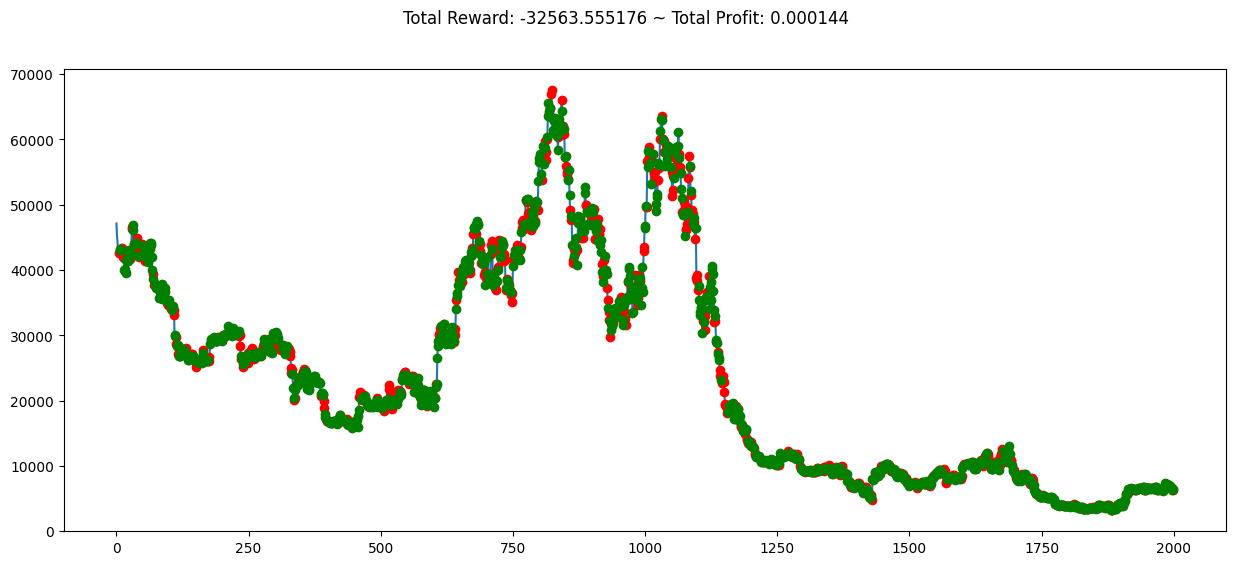

In [9]:
random_moves(env)

As you see, the starting position of the environment is always Short.
As you see, the first 5 points (window_size=5) on the plot don't have a position. Because they aren't involved
Window size is just how many starting points we want to skip, if set to 1000, we skip first 1000 points

## 3. Build environment and train

different algorithms from baselines package:
https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html


* training is performed from day 5 until day 2300

* frame bound need to start from at least window size

* Properties:

        frame_bound: A tuple which specifies the start and end of df. It is passed in the class' constructor.
        
        trade_fee_bid_percent: A default constant fee percentage for bids. For example with trade_fee_bid_percent=0.01, you will lose 1% of your money every time you sell your shares.
        
        trade_fee_ask_percent: A default constant fee percentage for asks. For example with trade_fee_ask_percent=0.005, you will lose 0.5% of your money every time you buy some shares.

In [10]:
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(5, 2300), window_size=5)
env = DummyVecEnv([env_maker])

model = A2C('MlpPolicy', env, verbose=1) # https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html#a2c-policies
#'CnnPolicy' , 'MultiInputPolicy'

model.learn(total_timesteps=10)


Using cuda device


# 4. Evaluation - random steps example

In [11]:
def evaluate(env:gym.Env, model, verbose:bool = False)-> list:
    obs, info = env.reset(seed=2023)
    actions=[]
    while True:
        obs = obs[np.newaxis, :]
        action, _states = model.predict(obs)

        obs, rewards, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        actions.append(('Buy' if action==[1] else 'Sell',rewards))
        if done:
            print("info", info)
            break
    
    plt.figure(figsize=(15,6))
    plt.cla()
    env.unwrapped.render_all()
    plt.show()
    if verbose:
        print(("------------Debug info:----------------"))
        print("----------------------------------------Actions:----------------------------------------")
        print(actions)
    return info

Stock environment and similar like forex
https://github.com/AminHP/gym-anytrading

Gym documentation:
https://gymnasium.farama.org/content/basic_usage/

info {'total_reward': -1693.00048828125, 'total_profit': 0.5573725173404964, 'position': <Positions.Short: 0>}


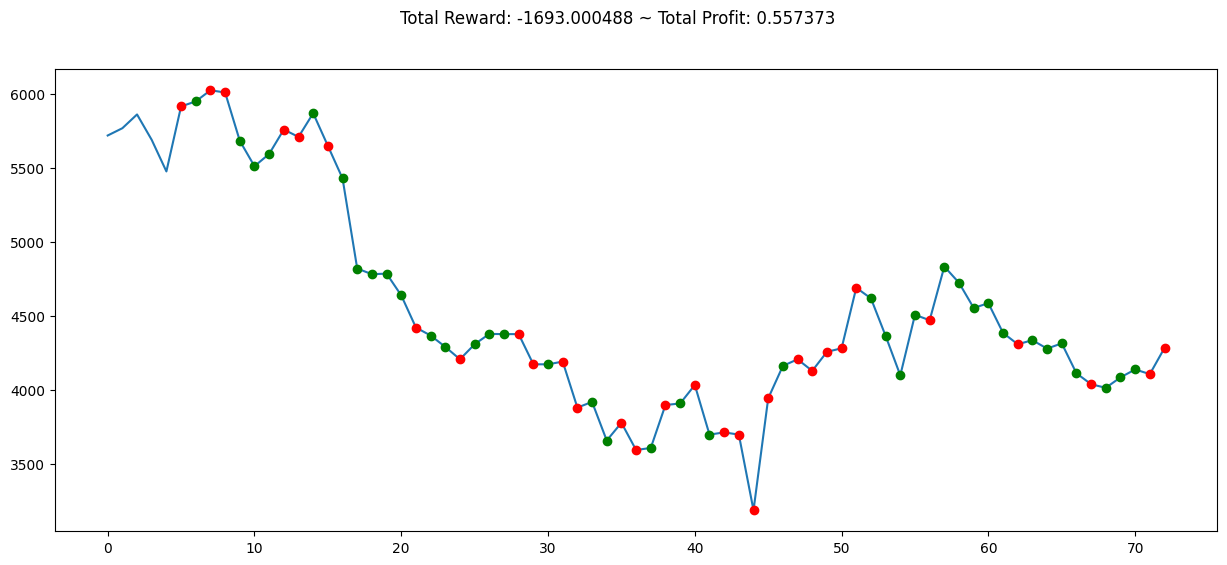

------------Debug info:----------------
----------------------------------------Actions:----------------------------------------
[('Buy', 0), ('Sell', 74.9501953125), ('Sell', 0), ('Buy', 0), ('Buy', 0), ('Buy', 0), ('Sell', 76.1201171875), ('Sell', 0), ('Buy', 0), ('Sell', -220.01025390625), ('Buy', 0), ('Buy', 0), ('Buy', 0), ('Buy', 0), ('Buy', 0), ('Sell', -1007.0), ('Buy', 0), ('Buy', 0), ('Sell', -160.41015625), ('Buy', 0), ('Buy', 0), ('Buy', 0), ('Sell', 68.509765625), ('Sell', 0), ('Buy', 0), ('Sell', 18.5), ('Sell', 0), ('Buy', 0), ('Buy', 0), ('Sell', -140.75), ('Sell', 0), ('Buy', 0), ('Sell', 290.010009765625), ('Buy', 0), ('Sell', 124.969970703125), ('Buy', 0), ('Sell', 14.9599609375), ('Sell', 0), ('Sell', 0), ('Sell', 0), ('Buy', 0), ('Sell', 44.75), ('Sell', 0), ('Sell', 0), ('Sell', 0), ('Sell', 0), ('Buy', 0), ('Buy', 0), ('Buy', 0), ('Buy', 0), ('Sell', -147.6298828125), ('Buy', 0), ('Buy', 0), ('Buy', 0), ('Buy', 0), ('Buy', 0), ('Sell', -524.900390625), ('Buy', 0)

{'total_reward': -1693.00048828125,
 'total_profit': 0.5573725173404964,
 'position': <Positions.Short: 0>}

In [12]:
# check different frame bound, best without overlap
env = gym.make('stocks-v0', df=df, frame_bound=(2300, 2500),window_size=5) #render_mode="human"
evaluate(env=env, model=model, verbose= True)

# Part 2. Technical indicators
https://www.youtube.com/watch?v=q-Uw9gC3D4o&t=343s

In [13]:
# need to change the sorting order to "from oldest to newest" order 
df.head()

,Unnamed: 0,Unix,Open,High,Low,Close,Volume,Volume USDT,tradecount,Adj Close
Date,,,,,,,,,,
2024-02-09,0,1707436800000,45288.66,48200.00,45242.12,47132.77,73503.48100,3.453043e+09,2323884,47132.77
2024-02-08,1,1707350400000,44349.60,45614.30,44331.10,45288.65,45439.62231,2.042912e+09,1863650,45288.65
2024-02-07,2,1707264000000,43098.96,44396.50,42788.00,44349.60,34392.59915,1.496014e+09,1378809,44349.60
2024-02-06,3,1707177600000,42708.70,43399.98,42574.00,43098.95,24675.85433,1.061050e+09,1120760,43098.95
2024-02-05,4,1707091200000,42582.88,43569.76,42258.10,42708.70,29467.75905,1.262621e+09,1317397,42708.70


In [14]:
df_sorted=df.sort_values('Date', ascending=True)
df_sorted.head()

,Unnamed: 0,Unix,Open,High,Low,Close,Volume,Volume USDT,tradecount,Adj Close
Date,,,,,,,,,,
2017-08-17,2367,1502928000000,4261.48,4485.39,4200.74,4285.08,795.150377,3.454770e+06,3427,4285.08
2017-08-18,2366,1503014400000,4285.08,4371.52,3938.77,4108.37,1199.888264,5.086958e+06,5233,4108.37
2017-08-19,2365,1503100800000,4108.37,4184.69,3850.00,4139.98,381.309763,1.549484e+06,2153,4139.98
2017-08-20,2364,1503187200000,4120.98,4211.08,4032.62,4086.29,467.083022,1.930364e+06,2321,4086.29
2017-08-21,2363,1503273600000,4069.13,4119.62,3911.79,4016.00,691.743060,2.797232e+06,3972,4016.00


In [15]:
env = gym.make('stocks-v0', df=df_sorted, frame_bound=(500, 700),window_size=5)

In [44]:
env.unwrapped.signal_features[:10]

array([[ 2.91024500e+04,  3.14431153e+04,  2.93398642e+04,
         4.93338226e+01, -1.57461897e+06],
       [ 2.90596000e+04,  2.75038769e+04,  2.93403942e+04,
         4.49406266e+01, -1.60212285e+06],
       [ 2.87230800e+04,  3.29966985e+04,  2.93084375e+04,
         3.76081816e+01, -1.63511955e+06],
       [ 2.51660000e+04,  1.00271540e+05,  2.91043775e+04,
         2.10266795e+01, -1.73539109e+06],
       [ 2.56190000e+04,  6.97906571e+04,  2.88515092e+04,
         1.86355242e+01, -1.80518175e+06],
       [ 2.58010900e+04,  2.61607534e+04,  2.85922550e+04,
         1.94327974e+01, -1.77902099e+06],
       [ 2.59710500e+04,  1.90569121e+04,  2.82938858e+04,
         2.10618597e+01, -1.75996408e+06],
       [ 2.58120000e+04,  3.02672423e+04,  2.80059633e+04,
         2.07452246e+01, -1.79023132e+06],
       [ 2.53000000e+04,  3.42470669e+04,  2.77226508e+04,
         2.03743084e+01, -1.82447839e+06],
       [ 2.58128200e+04,  4.40236998e+04,  2.74732083e+04,
         2.77627603e+01

info {'total_reward': 4385.37060546875, 'total_profit': 0.9632671085142563, 'position': <Positions.Short: 0>}


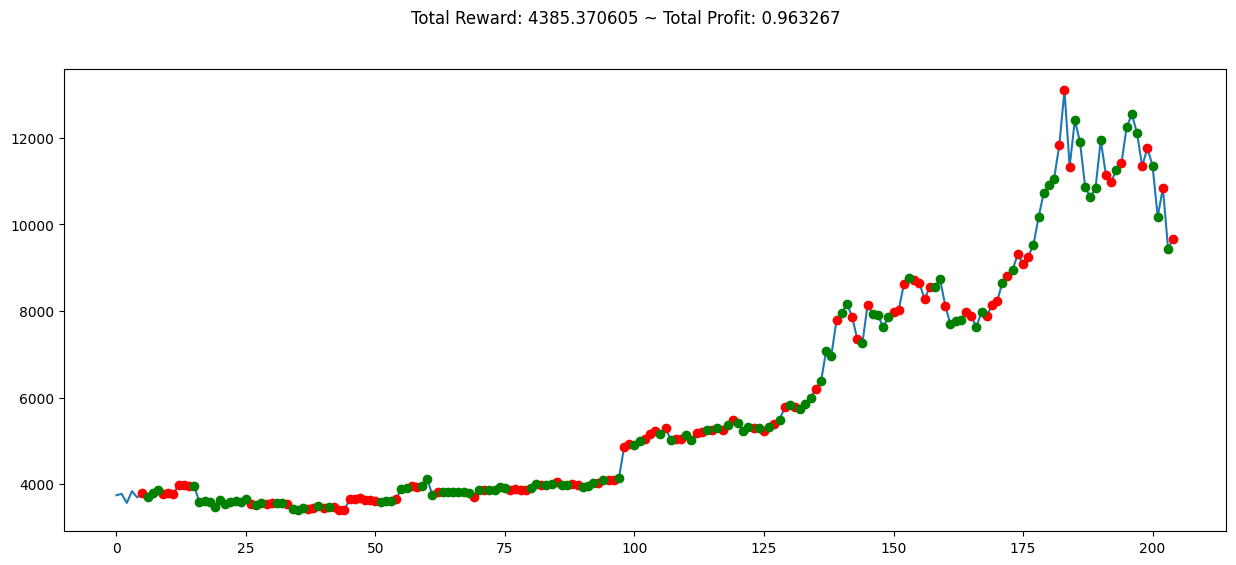

In [17]:
random_moves(env)

# 2.1 Data Indicators

In [18]:
from gym_anytrading.envs import StocksEnv
from finta import TA # https://github.com/peerchemist/fintahttps://github.com/peerchemist/finta

In [19]:
df_sorted.dtypes
# Volume column is string (23,333,333) not float (23333333)
# df_sorted['Volume'] = df['Volume'].apply(lambda x: float(x.replace(",","")))

Unnamed: 0       int64
Unix             int64
Open           float64
High           float64
Low            float64
Close          float64
Volume         float64
Volume USDT    float64
tradecount       int64
Adj Close      float64
dtype: object

In [20]:
df_sorted.head()

,Unnamed: 0,Unix,Open,High,Low,Close,Volume,Volume USDT,tradecount,Adj Close
Date,,,,,,,,,,
2017-08-17,2367,1502928000000,4261.48,4485.39,4200.74,4285.08,795.150377,3.454770e+06,3427,4285.08
2017-08-18,2366,1503014400000,4285.08,4371.52,3938.77,4108.37,1199.888264,5.086958e+06,5233,4108.37
2017-08-19,2365,1503100800000,4108.37,4184.69,3850.00,4139.98,381.309763,1.549484e+06,2153,4139.98
2017-08-20,2364,1503187200000,4120.98,4211.08,4032.62,4086.29,467.083022,1.930364e+06,2321,4086.29
2017-08-21,2363,1503273600000,4069.13,4119.62,3911.79,4016.00,691.743060,2.797232e+06,3972,4016.00


### SMA, RSI, OBV Indicators

In [21]:
df_sorted['SMA']= TA.SMA(df_sorted,12)
df_sorted['RSI']=TA.RSI(df_sorted)
df_sorted['OBV']=TA.OBV(df_sorted)
df_sorted.fillna(0, inplace=True)
df_sorted.head(25)

,Unnamed: 0,Unix,Open,High,Low,Close,Volume,Volume USDT,tradecount,Adj Close,SMA,RSI,OBV
Date,,,,,,,,,,,,,
2017-08-17,2367,1502928000000,4261.48,4485.39,4200.74,4285.08,795.150377,3.454770e+06,3427,4285.08,0.000000,0.000000,0.000000
2017-08-18,2366,1503014400000,4285.08,4371.52,3938.77,4108.37,1199.888264,5.086958e+06,5233,4108.37,0.000000,0.000000,-1199.888264
2017-08-19,2365,1503100800000,4108.37,4184.69,3850.00,4139.98,381.309763,1.549484e+06,2153,4139.98,0.000000,16.152451,-818.578501
2017-08-20,2364,1503187200000,4120.98,4211.08,4032.62,4086.29,467.083022,1.930364e+06,2321,4086.29,0.000000,12.468550,-1285.661523
2017-08-21,2363,1503273600000,4069.13,4119.62,3911.79,4016.00,691.743060,2.797232e+06,3972,4016.00,0.000000,9.434761,-1977.404583
2017-08-22,2362,1503360000000,4016.00,4104.82,3400.00,4040.00,966.684858,3.752506e+06,6494,4040.00,0.000000,16.872115,-1010.719725
2017-08-23,2361,1503446400000,4040.00,4265.80,4013.89,4114.01,1001.136565,4.148686e+06,8629,4114.01,0.000000,34.684982,-9.583160
2017-08-24,2360,1503532800000,4147.00,4371.68,4085.01,4316.01,787.418753,3.296476e+06,6247,4316.01,0.000000,59.925592,777.835593
2017-08-25,2359,1503619200000,4316.01,4453.91,4247.48,4280.68,573.612740,2.484637e+06,6554,4280.68,0.000000,55.859643,204.222853


In [22]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:,['Low','Volume','SMA','RSI','OBV']].to_numpy()[start:end]
    return prices, signal_features

In [23]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

env2 = MyCustomEnv(df=df_sorted, window_size=12, frame_bound=(25,2300)) # training data from day 12  till 50

In [43]:
env2.prices[:10]  # prices matching the Low values

array([4416.01, 4555.14, 4654.88, 4286.87, 4298.33, 3972.51, 3603.  ,
       4335.26, 4438.19, 4028.93])

In [25]:
df_sorted.head() # matching values

,Unnamed: 0,Unix,Open,High,Low,Close,Volume,Volume USDT,tradecount,Adj Close,SMA,RSI,OBV
Date,,,,,,,,,,,,,
2017-08-17,2367,1502928000000,4261.48,4485.39,4200.74,4285.08,795.150377,3.454770e+06,3427,4285.08,0.0,0.000000,0.000000
2017-08-18,2366,1503014400000,4285.08,4371.52,3938.77,4108.37,1199.888264,5.086958e+06,5233,4108.37,0.0,0.000000,-1199.888264
2017-08-19,2365,1503100800000,4108.37,4184.69,3850.00,4139.98,381.309763,1.549484e+06,2153,4139.98,0.0,16.152451,-818.578501
2017-08-20,2364,1503187200000,4120.98,4211.08,4032.62,4086.29,467.083022,1.930364e+06,2321,4086.29,0.0,12.468550,-1285.661523
2017-08-21,2363,1503273600000,4069.13,4119.62,3911.79,4016.00,691.743060,2.797232e+06,3972,4016.00,0.0,9.434761,-1977.404583


In [48]:
env2.signal_features[:10] # are matching Low, Volume, SMA, RSI, OBV

array([[4416.01      ,  808.468771  , 4264.14416667,   69.94164205,
         480.556209  ],
       [4555.14      ,  556.956802  , 4312.88666667,   76.10633327,
        1037.513011  ],
       [4654.88      ,  560.666366  , 4375.27166667,   79.09840528,
        1598.179377  ],
       [4286.87      ,  929.148595  , 4413.28333333,   54.75204706,
         669.030782  ],
       [4298.33      ,  691.216198  , 4452.37333333,   56.22944847,
        1360.24698   ],
       [3972.51      , 1394.644614  , 4451.215     ,   40.47336874,
         -34.397634  ],
       [3603.        , 1228.938157  , 4455.42      ,   50.25094891,
        1194.540523  ],
       [4335.26      ,  807.363726  , 4483.6775    ,   57.41456121,
        2001.904249  ],
       [4438.19      ,  500.429975  , 4513.19166667,   59.20859949,
        2502.334224  ],
       [4028.93      , 1132.255046  , 4510.92416667,   47.05919607,
        1370.079178  ]])

## 2.2 Build environment and train

In [27]:
env_maker= lambda: env2
env = DummyVecEnv([env_maker])

A2C is meant to be run primarily on the CPU, especially when you are not using a CNN. To improve CPU utilization, try turning off the GPU and using SubprocVecEnv instead of the default DummyVecEnv.
A2C.png      


<div>
<img src="../av_crypto_trading/docs/A2C.png" width="1500"/>
</div>

In [28]:
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10) #1000000

Using cuda device


info {'total_reward': 11929.130000000037, 'total_profit': 0.0004864171287145071, 'position': <Positions.Long: 1>}


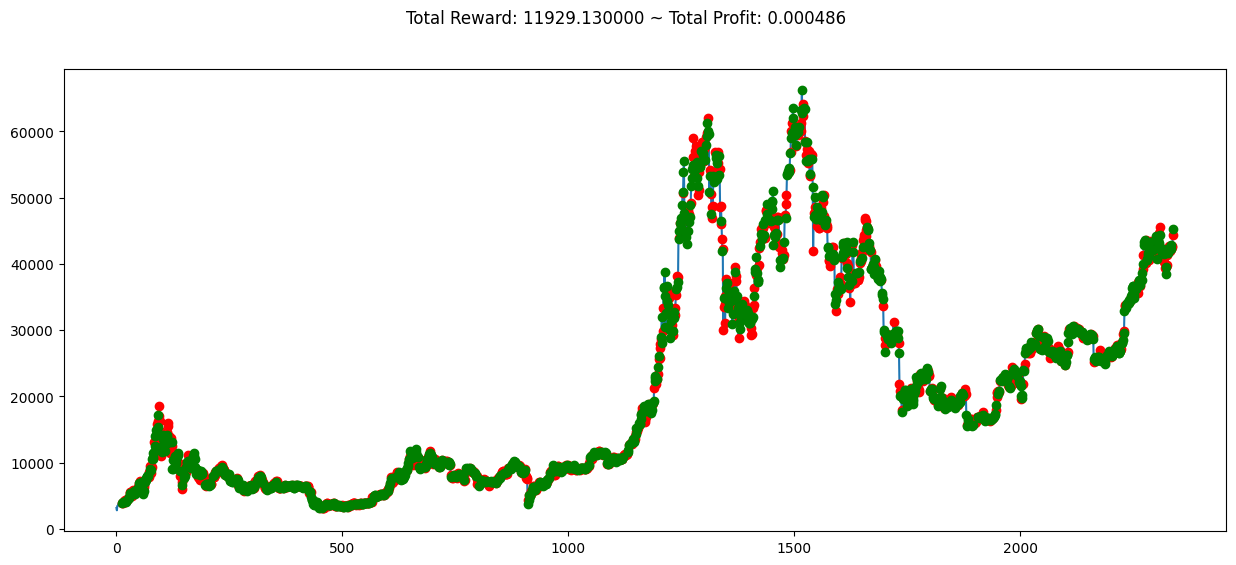

{'total_reward': 11929.130000000037,
 'total_profit': 0.0004864171287145071,
 'position': <Positions.Long: 1>}

In [49]:
env=MyCustomEnv(df=df_sorted, window_size=12, frame_bound=(40,2500)) 
evaluate(env, model, verbose=False)

# ML flow experiments tracker

In [30]:
import sys
from typing import Any, Dict, Tuple, Union

import mlflow
import numpy as np

from stable_baselines3.common.logger import HumanOutputFormat, KVWriter, Logger


class MLflowOutputFormat(KVWriter):
    """
    Dumps key/value pairs into MLflow's numeric format.
    """

    def write(
        self,
        key_values: Dict[str, Any],
        key_excluded: Dict[str, Union[str, Tuple[str, ...]]],
        step: int = 0,
    ) -> None:

        for (key, value), (_, excluded) in zip(
            sorted(key_values.items()), sorted(key_excluded.items())
        ):

            if excluded is not None and "mlflow" in excluded:
                continue

            if isinstance(value, np.ScalarType):
                if not isinstance(value, str):
                    mlflow.log_metric(key, value, step)


loggers = Logger(
    folder=None,
    output_formats=[HumanOutputFormat(sys.stdout), MLflowOutputFormat()],
)



In [31]:
with mlflow.start_run():
    # model = SAC("MlpPolicy", "Pendulum-v1", verbose=2)
    model = A2C('MlpPolicy', env, verbose=2)    
    
    # Set custom logger
    model.set_logger(loggers)
    
    # model.learn(total_timesteps=1000000, log_interval=1)
    model.learn(total_timesteps=10)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


To run mlflow ui in terminal: ```mlflow ui``` 
In examples directory!

In [32]:
#!mlflow ui

### Saving and loading the model

In [33]:
#model.save("mlruns/models/model_RL_BTC")

In [34]:
#del model

In [35]:
#model = A2C.load("mlruns/models/model_RL_BTC", env=env)

info {'total_reward': 4129.029999999988, 'total_profit': 0.6357431796017055, 'position': <Positions.Long: 1>}


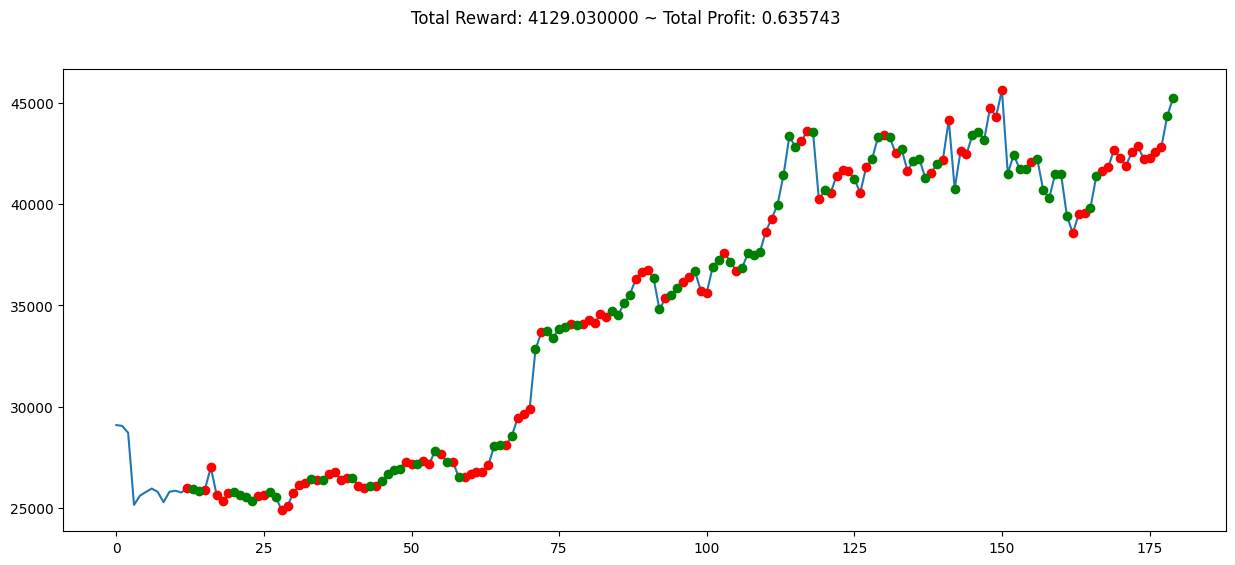

{'total_reward': 4129.029999999988,
 'total_profit': 0.6357431796017055,
 'position': <Positions.Long: 1>}

In [36]:
env=MyCustomEnv(df=df_sorted, window_size=12, frame_bound=(2200,2900)) 
evaluate(env, model)

# Experimental saving session of notebook

In [37]:
#!pip install dill
# import dill
# dill.dump_module('notebook_env.db')

In [38]:
# import dill
# dill.load_session('notebook_env.db')

# Part 3. Smart Money Concept
literature: <a href="https://pl.tradingview.com/script/CnB3fSph-Smart-Money-Concepts-LuxAlgo/"> https://pl.tradingview.com/script/CnB3fSph-Smart-Money-Concepts-LuxAlgo/ </a>
repository: <a href="https://github.com/joshyattridge/smartmoneyconcepts/tree/master"> https://github.com/joshyattridge/smartmoneyconcepts/tree/master</a>

In [39]:
# package need to be added via  pycharm env
from smartmoneyconcepts import smc


In [57]:
df_smc= df_sorted.reset_index()
#df_smc=df_smc.drop('FVG',axis=1)

In [55]:
df_smc.head()

,Date,Unnamed: 0,Unix,Open,High,Low,Close,Volume,Volume USDT,tradecount,Adj Close,SMA,RSI,OBV
0,2017-08-17,2367,1502928000000,4261.48,4485.39,4200.74,4285.08,795.150377,3.454770e+06,3427,4285.08,0.0,0.000000,0.000000
1,2017-08-18,2366,1503014400000,4285.08,4371.52,3938.77,4108.37,1199.888264,5.086958e+06,5233,4108.37,0.0,0.000000,-1199.888264
2,2017-08-19,2365,1503100800000,4108.37,4184.69,3850.00,4139.98,381.309763,1.549484e+06,2153,4139.98,0.0,16.152451,-818.578501
3,2017-08-20,2364,1503187200000,4120.98,4211.08,4032.62,4086.29,467.083022,1.930364e+06,2321,4086.29,0.0,12.468550,-1285.661523
4,2017-08-21,2363,1503273600000,4069.13,4119.62,3911.79,4016.00,691.743060,2.797232e+06,3972,4016.00,0.0,9.434761,-1977.404583


In [58]:
df_smc= pd.merge(df_smc,smc.fvg(df), left_index=True, right_index=True)
swing_highs_lows= smc.swing_highs_lows(df, swing_length = 50)
# df_smc= pd.merge(df_smc,smc.swing_tops_bottoms(df, swing_length=10), left_index=True, right_index=True)
df_smc= pd.merge(df_smc,smc.bos_choch(df, swing_highs_lows, close_break = True), left_index=True, right_index=True)
df_smc= pd.merge(df_smc,smc.ob(df, swing_highs_lows, close_mitigation = False), left_index=True, right_index=True)
# df_smc= pd.merge(df_smc,smc.vob(df_sorted), left_index=True, right_index=True)
df_smc= pd.merge(df_smc, smc.retracements(df, swing_highs_lows), left_index=True, right_index=True)
df_smc= pd.merge(df_smc, smc.previous_high_low(df, time_frame = "1D"), left_index=True, right_index=True)
df_smc.set_index('Date', inplace=True)
df_smc.fillna(0, inplace=True)
df_smc.head()

,Unnamed: 0,Unix,Open,High,Low,Close,Volume,Volume USDT,tradecount,Adj Close,SMA,RSI,OBV,FVG,Top_x,Bottom_x,MitigatedIndex_x,BOS,CHOCH,Level,BrokenIndex,OB,Top_y,Bottom_y,OBVolume,MitigatedIndex_y,Percentage,Direction,CurrentRetracement%,DeepestRetracement%,PreviousHigh,PreviousLow,BrokenHigh,BrokenLow
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-17,2367,1502928000000,4261.48,4485.39,4200.74,4285.08,795.150377,3.454770e+06,3427,4285.08,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,44396.500000,42788.000000,1,0
2017-08-18,2366,1503014400000,4285.08,4371.52,3938.77,4108.37,1199.888264,5.086958e+06,5233,4108.37,0.0,0.000000,-1199.888264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,43399.980469,42574.000000,1,0
2017-08-19,2365,1503100800000,4108.37,4184.69,3850.00,4139.98,381.309763,1.549484e+06,2153,4139.98,0.0,16.152451,-818.578501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,43569.761719,42258.101562,1,0
2017-08-20,2364,1503187200000,4120.98,4211.08,4032.62,4086.29,467.083022,1.930364e+06,2321,4086.29,0.0,12.468550,-1285.661523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,43119.039062,42222.000000,1,0
2017-08-21,2363,1503273600000,4069.13,4119.62,3911.79,4016.00,691.743060,2.797232e+06,3972,4016.00,0.0,9.434761,-1977.404583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,43380.011719,42880.000000,1,1


In [61]:
def add_signals_smc(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:,['Low','Volume','FVG',
                                    'Top_x','Bottom_x', 'MitigatedIndex_x',
                                    'BOS', 'CHOCH', 'Level',
                                    'BrokenIndex',
                                    'OB', 'Top_y', 'Bottom_y', 'OBVolume', 'MitigatedIndex_y',
                                    'CurrentRetracement%', 'DeepestRetracement%',
                                    'PreviousHigh', 'PreviousLow', 'BrokenHigh']].to_numpy()[start:end]
    return prices, signal_features

In [62]:
class MyCustomEnvSMC(StocksEnv):
    _process_data = add_signals_smc

env_smc = MyCustomEnvSMC(df=df_smc, window_size=12, frame_bound=(25,2300))

In [64]:
env_smc.signal_features[:10]

array([[4.41601000e+03, 8.08468771e+02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.03002383e+04, 3.95500000e+04, 1.00000000e+00],
       [4.55514000e+03, 5.56956802e+02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.05550000e+04, 3.94841914e+04, 1.00000000e+00],
       [4.65488000e+03, 5.60666366e+02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.0000

In [65]:
env_maker_smc= lambda: env_smc
env = DummyVecEnv([env_maker_smc])

In [68]:
with mlflow.start_run():
    model = A2C('MlpPolicy', env, verbose=2)    
    
    # Set custom logger
    model.set_logger(loggers)
    
    # model.learn(total_timesteps=1000000, log_interval=1)
    model.learn(total_timesteps=100000)

Using cuda device
------------------------------------
| time/                 |          |
|    fps                | 1045     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.678   |
|    explained_variance | 0.00419  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 28.7     |
|    value_loss         | 2.37e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 969      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.625   |
|    explained_variance | 0.000251 |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -51.6    |
|    value_loss     

KeyboardInterrupt: 

info {'total_reward': 5184.139999999999, 'total_profit': 0.9493519116959532, 'position': <Positions.Short: 0>}


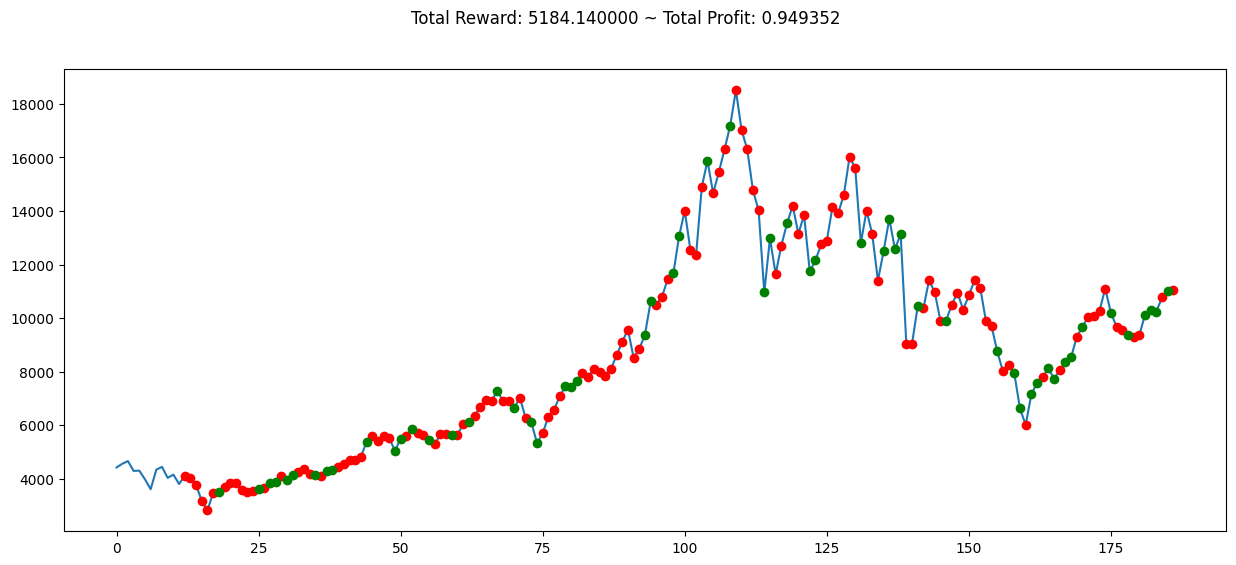

{'total_reward': 5184.139999999999,
 'total_profit': 0.9493519116959532,
 'position': <Positions.Short: 0>}

In [67]:
env_smc = MyCustomEnvSMC(df=df_smc, window_size=12, frame_bound=(25,200))
evaluate(env_smc, model)

In [ ]:
# model.save("mlruns/models/model_RL_SMC_100k")

# Model should be able to wait a couple of days before deciding about the sell or buy
It is worth exploring the feature importance and normalization, regularization 